In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy
from transformers import *

from path_explain import utils
from embedding_explainer_bert import EmbeddingExplainerTF

utils.set_up_environment(visible_devices='0')
from path_explain.plot.text import text_plot, matrix_interaction_plot, bar_interaction_plot
from path_explain.plot.scatter import _set_axis_config
from path_explain.plot import colors

In [3]:
sys.path.append("../../src")
from application_utils.text_utils import prepare_huggingface_data

## Get Model

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_path = "../../downloads/pretrained_bert"
model = TFBertForSequenceClassification.from_pretrained(model_path, from_pt=True)

In [5]:
# Check TFBertMainLayer in "https://github.com/huggingface/transformers/blob/601ac5b1dc1438f00d09696588f2deb0f045ae3b/src/transformers/modeling_tf_bert.py#L475"

def embedding_model(batch_ids):
    batch_embedding = model.bert.embeddings( (batch_ids, None, None, None ))
    return batch_embedding

def prediction_model(batch_embedding, attention_mask):
#     attention_mask = tf.ones(batch_embedding.shape[:2])  # not exactly sure about this
    extended_attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]
    extended_attention_mask = tf.cast(extended_attention_mask, tf.float32)
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
    head_mask = [None] * model.bert.num_hidden_layers
    
    encoder_outputs = model.bert.encoder([batch_embedding, extended_attention_mask, head_mask], training=False)

    sequence_output = encoder_outputs[0]
    pooled_output = model.bert.pooler(sequence_output)    
    logits = model.classifier(pooled_output)
    return logits 


def get_predictions(sentences, embedding_only=False):
    def print_sentence(index):
        confidence = batch_conf[index]
        predicted_label = batch_pred[index]
        true_label = batch_labels[index]

        encoded_sentence = batch_ids[index].numpy()
        encoded_sentence = encoded_sentence[encoded_sentence != 0]

        print(tokenizer.decode(encoded_sentence))
        print('This sentence is:\t{}'.format('positive' if true_label == 1 else 'negative'))
        print('BERT predicts:\t{} (confidence {:.4f})'.format('positive' if predicted_label == 1 else 'negative',
                                                               batch_conf[index, predicted_label]))
        print('-------------------------')
        
        
    batch_input = prepare_huggingface_data(sentences, tokenizer)

    for key in batch_input:
        batch_input[key] = tf.convert_to_tensor(batch_input[key])
        
    batch_ids = batch_input['input_ids']
    attention_mask = batch_input["attention_mask"]
    
    batch_conf = model(batch_input)[0]
    batch_conf = scipy.special.softmax(batch_conf, axis=-1)
    batch_pred = np.argmax(batch_conf, axis=-1)
    
    batch_embedding = embedding_model(batch_ids)
    batch_baseline = np.zeros((1, batch_ids.shape[1]), dtype=np.int64)    
    baseline_embedding = embedding_model(batch_baseline)

    batch_predictions = prediction_model(batch_embedding, attention_mask)

    orig_token_list = []
    for i in range(batch_ids.shape[0]):
        ids = batch_ids[i].numpy()
        tokens = tokenizer.convert_ids_to_tokens(ids)
        orig_token_list.append(tokens)
        
    return batch_predictions, orig_token_list, batch_embedding, baseline_embedding, attention_mask


## Get Data

In [6]:
sentences = [
#     'This movie was bad',
#     'This movie was not bad',
#     'A movie',
#     'A bad movie',
#     'A bad terrible movie',
#     'A bad terrible awful movie',
    'A bad, terrible, awful, horrible movie'
]

## Get Predictions

In [ ]:
batch_predictions, orig_token_list, batch_embedding, baseline_embedding, attention_mask = get_predictions(sentences)

In [8]:
batch_predictions.numpy()

array([[ 3.510431, -4.253784]], dtype=float32)

## Explain Predictions

In [9]:
explainer = EmbeddingExplainerTF(prediction_model)
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=20,
                                      num_samples=50,
                                      use_expectation=False,
                                      output_indices=1,
                                      verbose=True,
                                      attention_mask=attention_mask)

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


In [10]:
interactions = explainer.interactions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=50,
                                      num_samples=50,
                                      use_expectation=False,
                                      output_indices=1,
                                      verbose=True,
                                      attention_mask=attention_mask)

100%|██████████| 1/1 [00:59<00:00, 59.62s/it]


In [11]:
token_list, attribution_list, interaction_list = utils.strip_tokens(orig_token_list, attributions, interactions)

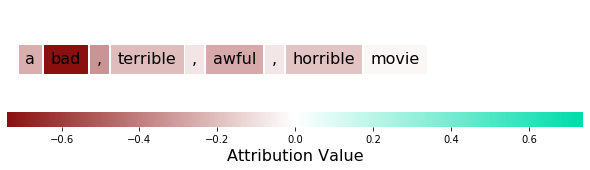

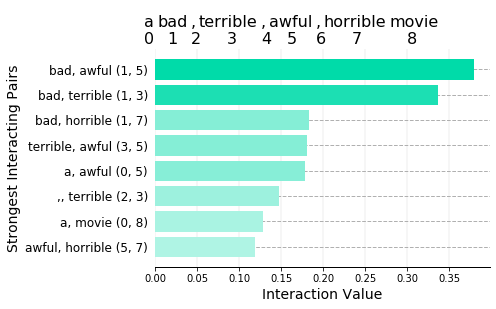

In [12]:
index = 0
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index], interaction_index=None, zero_diagonals=False, include_legend=True)
# plt.savefig('fincher_text.pdf')
ax, text_ax = bar_interaction_plot(interaction_list[index], token_list[index], top_k=8)
# plt.savefig('fincher_bar.pdf')
print("\n\n")